In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from mlxtend.evaluate import plot_decision_regions

%matplotlib inline

# Perceptron

In [3]:
class Perceptron(object):
    
    def __init__(self, eta=.01, n_iter=10, random=False, seed=1):
        
        self.eta = eta
        self.n_iter = n_iter
        self.random = random
        self.seed = seed
        
    def fit(self, X, y):
        
        # adding x0
        X = np.c_[np.ones(X.shape[0]), X]
        
        if self.random:
            
            np.random.seed(self.seed)
            self.w_ = np.random.random(X.shape[1])
        else:
            
            self.w_ = np.zeros(X.shape[1])

        self.errors_ = []
        
        for _ in range(self.n_iter):
            
            errors = 0
            for xi, target in zip(X, y):
                
                update = self.eta * (target - self.__predict(xi))
                self.w_ += update * xi
                errors += int(update != 0.0)
            
            self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        
        return np.dot(X, self.w_)
    
    def __predict(self, X):
        
        return np.where(self.net_input(X) >= 0.0, 1, -1)
    
    def predict(self, X):
        
        X = np.c_[np.ones(X.shape[0]), X]
        
        return self.__predict(X)

# Iris dataset

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

In [5]:
y = df.iloc[:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[:100, [0, 2]].values

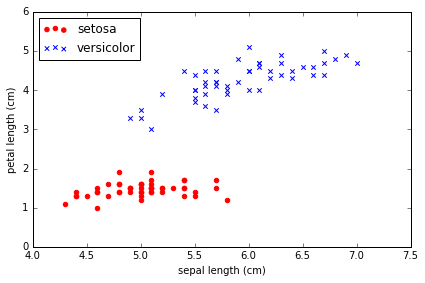

In [6]:
plt.scatter(X[:50, 0], X[:50, 1], color='r', marker='o', label='setosa')
plt.scatter(X[50:, 0], X[50:, 1], color='b', marker='x', label='versicolor')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend(loc='upper left')
plt.tight_layout()

# Perceptron(iris)

### w = ones

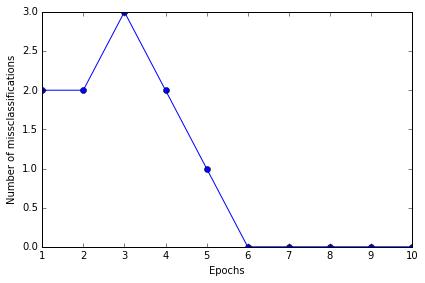

In [7]:
p_ones = Perceptron(eta=.1, n_iter=10)
p_ones.fit(X, y)

plt.plot(range(1, len(p_ones.errors_) + 1), p_ones.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of missclassifications')
plt.tight_layout()

### w = random

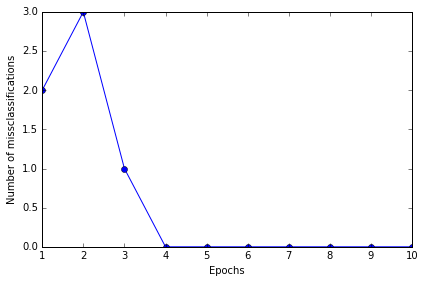

In [8]:
p_rand = Perceptron(eta=.1, n_iter=10, random=True, seed=5)
p_rand.fit(X, y)

plt.plot(range(1, len(p_rand.errors_) + 1), p_rand.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of missclassifications')
plt.tight_layout()

# Ploting decision regions

array([-0.4 , -0.68,  1.82])

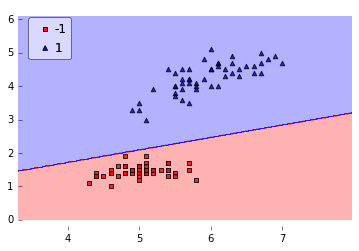

In [9]:
plot_decision_regions(X, y, p_ones, legend=2)
p_ones.w_

array([-0.17800683, -0.36926769,  0.96671916])

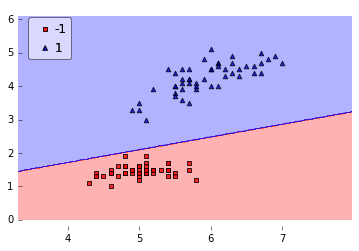

In [10]:
plot_decision_regions(X, y, p_rand, legend=2)
p_rand.w_

# AdalineGD

In [61]:
class AdalineGD(object):
    
    def __init__(self, eta=.01, n_iter=50, ada_eta=None):
        
        self.eta = eta
        self.n_iter = n_iter
        self.ada_eta = ada_eta
            
    def learning_rate(self, i):
        
        if self.ada_eta:
            
            return self.ada_eta[0] / (i + self.ada_eta[1])
        
        else:
            
            return self.eta
        
    def fit(self, X, y):
        
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.learning_rate(i) * X.T.dot(errors)
            self.w_[0] += self.learning_rate(i) * errors.sum()
            cost = (errors**2).sum()/ 2.
            self.cost_.append(cost)
        
        return self
    
    def net_input(self, X):
        
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        
        return self.net_input(X)
    
    def predict(self, X):
        
        return np.where(self.activation(X) >= .0, 1, -1)

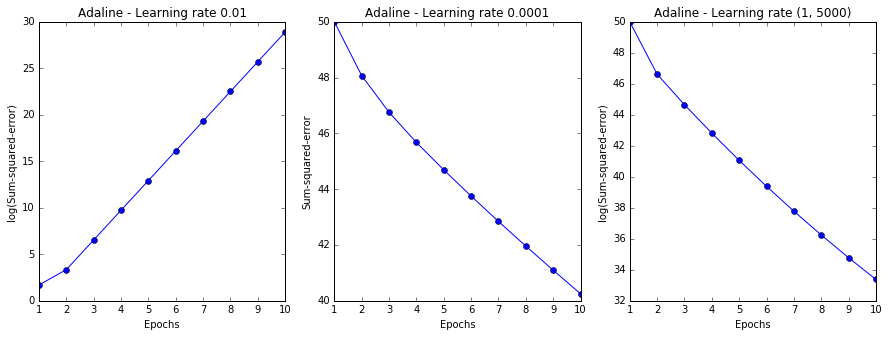

In [62]:
n_iter = 10
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ada1 = AdalineGD(n_iter=n_iter, eta=.01).fit(X, y)
ada2 = AdalineGD(n_iter=n_iter, eta=.0001).fit(X, y)
ada3 = AdalineGD(n_iter=n_iter, ada_eta=(1, 5000)).fit(X, y)

ax[0].plot(range(1, n_iter + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate {}'.format(ada1.eta))

ax[1].plot(range(1, n_iter + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate {}'.format(ada2.eta))

ax[2].plot(range(1, n_iter + 1), ada3.cost_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('log(Sum-squared-error)')
ax[2].set_title('Adaline - Learning rate {}'.format(ada3.ada_eta))

## AdalineGD + standard scaling

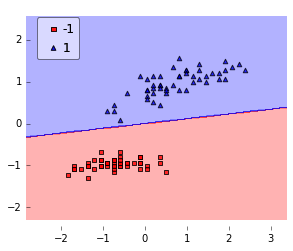

In [63]:
X_std = np.copy(X)

X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada = AdalineGD(n_iter = 15, eta = .01).fit(X_std, y)

plot_decision_regions(X_std, y, ada, legend=2)
plt.gca().set_aspect('equal')

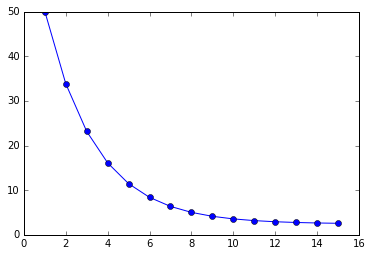

In [64]:
plt.plot(range(1, 15 + 1), ada.cost_, marker='o')

# Stochastic AdalineGD

In [85]:
class AdalineSGD(object):
    
    def __init__(self, eta=.01, n_iter=10, shuffle=True, random_state=None):
        
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            
            np.random.seed(random_state)
            
    def fit(self, X, y):

        self._initialize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):

            if self.shuffle:

                X, y = self._shuffle(X, y)

            cost = []
            for xi, target in zip(X, y):

                cost.append(self._update_weights(xi, target))

            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)

        return self

    def partial_fit(self, X, y):

        if not self.w_initialized:

            self._initialize_weights(X.shape[1])

        if y.ravel().shape[0] > 1:

            for xi, target in zip(X, y):

                self._update_weights(xi, target)

        else:

            self._update_weights(X, y)

        return self

    def _shuffle(self, X, y):

        r = np.random.permutation(len(y))

        return X[r], y[r]

    def _initialize_weights(self, m):

        self.w_ = np.zeros(1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):

        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi * error
        self.w_[0] += self.eta * error
        cost = .5 * error ** 2

        return cost

    def net_input(self, X):

        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):

        return self.net_input(X)

    def predict(self, X):

        return np.where(self.activation(X) >= .0, 1, -1)

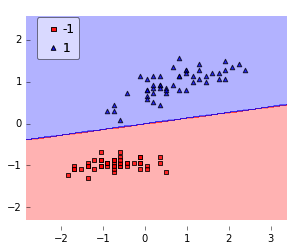

In [86]:
ada = AdalineSGD(n_iter = 15, eta = .01, random_state = 0).fit(X_std, y)

plot_decision_regions(X_std, y, ada, legend=2)
plt.gca().set_aspect('equal')

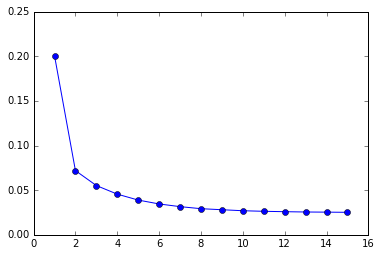

In [84]:
plt.plot(range(1, 15 + 1), ada.cost_, marker='o')